In [1]:
import matplotlib as mpl
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv('data/pix_train.csv', header = None)
df=df[1:]
# df=pd.DataFrame(df[0].str.split(expand=True))
df=df.astype(int)
data=df.values
df = pd.read_csv('data/pix_test.csv', header = None)
df=df[1:]
df=df.astype(int)
test=df.values

In [3]:
X_train=data[:,0:240]
y_train=data[:,240]
X_test=test[:,0:240]
y_test=test[:,240]
y_train0 = tf.one_hot(y_train,10)
y_test0 = tf.one_hot(y_test,10)

In [4]:
# 构建神经网络(4层、1 input,2hidden,ioutput）
n_uint_hidden_1 = 256
n_uint_hidden_2 = 128
n_input = 240#输入的一个样本是15*16像素的
n_classes = 10#输出类别数目

In [5]:
# 定义输入占位符
x = tf.placeholder(tf.float32,shape = [None,n_input],name = 'x')
y = tf.placeholder(tf.float32,shape = [None,n_classes],name = 'y')

In [6]:
# 初始化的w和b

weights = {
    "w1":tf.Variable(tf.random_normal(shape=[n_input,n_uint_hidden_1],stddev = 0.1)),
    "w2":tf.Variable(tf.random_normal(shape=[n_uint_hidden_1,n_uint_hidden_2],stddev = 0.1)),
    "w3":tf.Variable(tf.random_normal(shape=[n_uint_hidden_2,n_classes],stddev = 0.1))
}

biases = {
    "b1":tf.Variable(tf.random_normal(shape=[n_uint_hidden_1],stddev=0.1)),
    "b2":tf.Variable(tf.random_normal(shape=[n_uint_hidden_2],stddev=0.1)),
    "out":tf.Variable(tf.random_normal(shape=[n_classes],stddev=0.1))
}

In [7]:
# 构建网络
def multiplayer_perceotron(_X,_weights,_biases):
#  第一层到第二层  input --> hidden1
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(_X,_weights['w1']),_biases['b1']))
#  第二层到第三层  hidden1 --> hidden
    layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1,_weights['w2']),_biases['b2']))
    return tf.add(tf.matmul(layer2,_weights['w3']),_biases['out'])

In [8]:
# 获取预测值
act= multiplayer_perceotron(x,weights,biases)

# tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y)
cost = tf.reduce_mean(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=act,labels=y)))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [9]:
# 使用梯度下降法求解
# 使用梯度下降最小化误差
# learning_rate:要注意,不要过大,过大可能不收敛,也不要过小,过小收敛速度比较慢
train = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost)

In [10]:
# 得到预测的类别是哪一个
# tf.argmax:对矩阵按行或列计算最大值对应的下标,和numpy中的一样
# tf.equal:是对比这两个矩阵或者向量的相等的元素,如果是相等的那就返回True
pred = tf.equal(tf.argmax(act,axis=1),tf.argmax(y,axis=1))
# 正确率(True转换为1,False转换为0)
acc = tf.reduce_mean(tf.cast(pred,tf.float32))#计算pred的平均值
# 计算 f1
model_pred = tf.argmax(act, 1)
model_True=tf.argmax(y,1)

In [11]:
# 初始化
init = tf.global_variables_initializer()

In [12]:
# 执行模型的训练
batch_size = 100  #每次处理的图片数
display_step = 1  #每4次迭代打印一次
times=3000

In [13]:
history={'loss':[],'val_loss':[],'accuracy':[],'val_accuracy':[]}

In [14]:
from sklearn.metrics import f1_score
with tf.Session() as sess:
    sess.run(init)
    y_train, y_test = sess.run([y_train0,y_test0])
#     模型的保存、持久化
    saver = tf.train.Saver()
    epoch = 0
    for temp in range(times):
        avg_cost = 0
        # 计算出总的批次
        total_batch = int(1600/batch_size)
        # 迭代更新
        for i in range(total_batch):
            batch_xs= X_train[i*batch_size:(i+1)*batch_size,:]
            batch_ys= y_train[i*batch_size:(i+1)*batch_size,:]
            feeds = {x:batch_xs,y:batch_ys}
        #           #模型训练
            sess.run(train,feed_dict=feeds)
            avg_cost+=sess.run(cost,feed_dict=feeds)
        avg_cost = avg_cost/total_batch
    #       显示误差率和训练集的正确率以此测试集的正确率
        if (epoch+1)%display_step == 0:
            history['loss'].append(avg_cost)
            print("批次:%03d  损失函数值:%.9f"%(epoch,avg_cost))
            feeds = {x:X_train,y:y_train}
            train_acc = sess.run(acc,feed_dict=feeds)
            history['accuracy'].append(train_acc)
            print("训练集准确率:%.3f"%train_acc)
            feeds = {x:X_test, y: y_test}
            test_acc,y_pred,y_true,costval = sess.run([acc,model_pred,model_True,cost], feed_dict=feeds)
            history['val_loss'].append(costval)
            history['val_accuracy'].append(test_acc)
            model_f1_score=f1_score(y_true,y_pred,average='micro')
            print( 'f1_score= "{:.9f}"'.format(model_f1_score))
            print("测试集准确率:%.3f" % test_acc)
            if train_acc>0.9 and test_acc>0.94:
                saver.save(sess,'./mn/model')
        epoch += 1

批次:000  损失函数值:nan
训练集准确率:0.066
f1_score= "0.071875000"
测试集准确率:0.072
批次:001  损失函数值:nan
训练集准确率:0.065
f1_score= "0.071875000"
测试集准确率:0.072
批次:002  损失函数值:nan
训练集准确率:0.068
f1_score= "0.065625000"
测试集准确率:0.066
批次:003  损失函数值:nan
训练集准确率:0.068
f1_score= "0.071875000"
测试集准确率:0.072
批次:004  损失函数值:nan
训练集准确率:0.072
f1_score= "0.075000000"
测试集准确率:0.075
批次:005  损失函数值:nan
训练集准确率:0.077
f1_score= "0.078125000"
测试集准确率:0.078
批次:006  损失函数值:nan
训练集准确率:0.084
f1_score= "0.075000000"
测试集准确率:0.075
批次:007  损失函数值:nan
训练集准确率:0.091
f1_score= "0.075000000"
测试集准确率:0.075
批次:008  损失函数值:nan
训练集准确率:0.095
f1_score= "0.081250000"
测试集准确率:0.081
批次:009  损失函数值:nan
训练集准确率:0.102
f1_score= "0.084375000"
测试集准确率:0.084
批次:010  损失函数值:nan
训练集准确率:0.109
f1_score= "0.090625000"
测试集准确率:0.091
批次:011  损失函数值:nan
训练集准确率:0.118
f1_score= "0.103125000"
测试集准确率:0.103
批次:012  损失函数值:nan
训练集准确率:0.126
f1_score= "0.109375000"
测试集准确率:0.109
批次:013  损失函数值:nan
训练集准确率:0.128
f1_score= "0.118750000"
测试集准确率:0.119
批次:014  损失函数值:nan
训练集准确率:0.135
f1_score= "0.1343

批次:123  损失函数值:nan
训练集准确率:0.495
f1_score= "0.484375000"
测试集准确率:0.484
批次:124  损失函数值:nan
训练集准确率:0.500
f1_score= "0.484375000"
测试集准确率:0.484
批次:125  损失函数值:nan
训练集准确率:0.503
f1_score= "0.484375000"
测试集准确率:0.484
批次:126  损失函数值:nan
训练集准确率:0.505
f1_score= "0.487500000"
测试集准确率:0.488
批次:127  损失函数值:nan
训练集准确率:0.507
f1_score= "0.493750000"
测试集准确率:0.494
批次:128  损失函数值:nan
训练集准确率:0.508
f1_score= "0.496875000"
测试集准确率:0.497
批次:129  损失函数值:nan
训练集准确率:0.511
f1_score= "0.506250000"
测试集准确率:0.506
批次:130  损失函数值:nan
训练集准确率:0.512
f1_score= "0.512500000"
测试集准确率:0.512
批次:131  损失函数值:nan
训练集准确率:0.515
f1_score= "0.512500000"
测试集准确率:0.512
批次:132  损失函数值:nan
训练集准确率:0.516
f1_score= "0.515625000"
测试集准确率:0.516
批次:133  损失函数值:nan
训练集准确率:0.519
f1_score= "0.525000000"
测试集准确率:0.525
批次:134  损失函数值:nan
训练集准确率:0.526
f1_score= "0.528125000"
测试集准确率:0.528
批次:135  损失函数值:nan
训练集准确率:0.527
f1_score= "0.528125000"
测试集准确率:0.528
批次:136  损失函数值:nan
训练集准确率:0.530
f1_score= "0.534375000"
测试集准确率:0.534
批次:137  损失函数值:nan
训练集准确率:0.531
f1_score= "0.5375

f1_score= "0.768750000"
测试集准确率:0.769
批次:246  损失函数值:nan
训练集准确率:0.737
f1_score= "0.768750000"
测试集准确率:0.769
批次:247  损失函数值:nan
训练集准确率:0.738
f1_score= "0.768750000"
测试集准确率:0.769
批次:248  损失函数值:nan
训练集准确率:0.739
f1_score= "0.768750000"
测试集准确率:0.769
批次:249  损失函数值:nan
训练集准确率:0.741
f1_score= "0.768750000"
测试集准确率:0.769
批次:250  损失函数值:nan
训练集准确率:0.741
f1_score= "0.771875000"
测试集准确率:0.772
批次:251  损失函数值:nan
训练集准确率:0.743
f1_score= "0.771875000"
测试集准确率:0.772
批次:252  损失函数值:nan
训练集准确率:0.743
f1_score= "0.775000000"
测试集准确率:0.775
批次:253  损失函数值:nan
训练集准确率:0.743
f1_score= "0.775000000"
测试集准确率:0.775
批次:254  损失函数值:nan
训练集准确率:0.743
f1_score= "0.775000000"
测试集准确率:0.775
批次:255  损失函数值:nan
训练集准确率:0.746
f1_score= "0.775000000"
测试集准确率:0.775
批次:256  损失函数值:nan
训练集准确率:0.748
f1_score= "0.775000000"
测试集准确率:0.775
批次:257  损失函数值:nan
训练集准确率:0.752
f1_score= "0.775000000"
测试集准确率:0.775
批次:258  损失函数值:nan
训练集准确率:0.752
f1_score= "0.775000000"
测试集准确率:0.775
批次:259  损失函数值:nan
训练集准确率:0.755
f1_score= "0.778125000"
测试集准确率:0.778
批次:260  损失函

f1_score= "0.812500000"
测试集准确率:0.812
批次:368  损失函数值:nan
训练集准确率:0.835
f1_score= "0.815625000"
测试集准确率:0.816
批次:369  损失函数值:nan
训练集准确率:0.835
f1_score= "0.815625000"
测试集准确率:0.816
批次:370  损失函数值:nan
训练集准确率:0.835
f1_score= "0.815625000"
测试集准确率:0.816
批次:371  损失函数值:nan
训练集准确率:0.835
f1_score= "0.815625000"
测试集准确率:0.816
批次:372  损失函数值:nan
训练集准确率:0.836
f1_score= "0.815625000"
测试集准确率:0.816
批次:373  损失函数值:nan
训练集准确率:0.836
f1_score= "0.815625000"
测试集准确率:0.816
批次:374  损失函数值:nan
训练集准确率:0.837
f1_score= "0.815625000"
测试集准确率:0.816
批次:375  损失函数值:nan
训练集准确率:0.837
f1_score= "0.815625000"
测试集准确率:0.816
批次:376  损失函数值:nan
训练集准确率:0.837
f1_score= "0.815625000"
测试集准确率:0.816
批次:377  损失函数值:nan
训练集准确率:0.840
f1_score= "0.815625000"
测试集准确率:0.816
批次:378  损失函数值:nan
训练集准确率:0.840
f1_score= "0.815625000"
测试集准确率:0.816
批次:379  损失函数值:nan
训练集准确率:0.840
f1_score= "0.815625000"
测试集准确率:0.816
批次:380  损失函数值:nan
训练集准确率:0.841
f1_score= "0.815625000"
测试集准确率:0.816
批次:381  损失函数值:nan
训练集准确率:0.841
f1_score= "0.815625000"
测试集准确率:0.816
批次:382  损失函

批次:489  损失函数值:nan
训练集准确率:0.872
f1_score= "0.865625000"
测试集准确率:0.866
批次:490  损失函数值:nan
训练集准确率:0.872
f1_score= "0.865625000"
测试集准确率:0.866
批次:491  损失函数值:nan
训练集准确率:0.873
f1_score= "0.865625000"
测试集准确率:0.866
批次:492  损失函数值:nan
训练集准确率:0.873
f1_score= "0.862500000"
测试集准确率:0.863
批次:493  损失函数值:nan
训练集准确率:0.873
f1_score= "0.862500000"
测试集准确率:0.863
批次:494  损失函数值:nan
训练集准确率:0.873
f1_score= "0.862500000"
测试集准确率:0.863
批次:495  损失函数值:nan
训练集准确率:0.873
f1_score= "0.862500000"
测试集准确率:0.863
批次:496  损失函数值:nan
训练集准确率:0.873
f1_score= "0.862500000"
测试集准确率:0.863
批次:497  损失函数值:nan
训练集准确率:0.873
f1_score= "0.862500000"
测试集准确率:0.863
批次:498  损失函数值:nan
训练集准确率:0.873
f1_score= "0.862500000"
测试集准确率:0.863
批次:499  损失函数值:nan
训练集准确率:0.873
f1_score= "0.862500000"
测试集准确率:0.863
批次:500  损失函数值:nan
训练集准确率:0.873
f1_score= "0.862500000"
测试集准确率:0.863
批次:501  损失函数值:nan
训练集准确率:0.874
f1_score= "0.862500000"
测试集准确率:0.863
批次:502  损失函数值:nan
训练集准确率:0.875
f1_score= "0.862500000"
测试集准确率:0.863
批次:503  损失函数值:nan
训练集准确率:0.877
f1_score= "0.8625

批次:611  损失函数值:nan
训练集准确率:0.895
f1_score= "0.881250000"
测试集准确率:0.881
批次:612  损失函数值:nan
训练集准确率:0.895
f1_score= "0.881250000"
测试集准确率:0.881
批次:613  损失函数值:nan
训练集准确率:0.895
f1_score= "0.881250000"
测试集准确率:0.881
批次:614  损失函数值:nan
训练集准确率:0.895
f1_score= "0.881250000"
测试集准确率:0.881
批次:615  损失函数值:nan
训练集准确率:0.895
f1_score= "0.881250000"
测试集准确率:0.881
批次:616  损失函数值:nan
训练集准确率:0.895
f1_score= "0.881250000"
测试集准确率:0.881
批次:617  损失函数值:nan
训练集准确率:0.895
f1_score= "0.881250000"
测试集准确率:0.881
批次:618  损失函数值:nan
训练集准确率:0.896
f1_score= "0.881250000"
测试集准确率:0.881
批次:619  损失函数值:nan
训练集准确率:0.896
f1_score= "0.881250000"
测试集准确率:0.881
批次:620  损失函数值:nan
训练集准确率:0.896
f1_score= "0.881250000"
测试集准确率:0.881
批次:621  损失函数值:nan
训练集准确率:0.896
f1_score= "0.881250000"
测试集准确率:0.881
批次:622  损失函数值:nan
训练集准确率:0.896
f1_score= "0.881250000"
测试集准确率:0.881
批次:623  损失函数值:nan
训练集准确率:0.896
f1_score= "0.881250000"
测试集准确率:0.881
批次:624  损失函数值:nan
训练集准确率:0.896
f1_score= "0.881250000"
测试集准确率:0.881
批次:625  损失函数值:nan
训练集准确率:0.896
f1_score= "0.8812

f1_score= "0.890625000"
测试集准确率:0.891
批次:733  损失函数值:nan
训练集准确率:0.908
f1_score= "0.890625000"
测试集准确率:0.891
批次:734  损失函数值:nan
训练集准确率:0.908
f1_score= "0.890625000"
测试集准确率:0.891
批次:735  损失函数值:nan
训练集准确率:0.909
f1_score= "0.890625000"
测试集准确率:0.891
批次:736  损失函数值:nan
训练集准确率:0.909
f1_score= "0.890625000"
测试集准确率:0.891
批次:737  损失函数值:nan
训练集准确率:0.909
f1_score= "0.890625000"
测试集准确率:0.891
批次:738  损失函数值:nan
训练集准确率:0.909
f1_score= "0.890625000"
测试集准确率:0.891
批次:739  损失函数值:nan
训练集准确率:0.909
f1_score= "0.890625000"
测试集准确率:0.891
批次:740  损失函数值:nan
训练集准确率:0.909
f1_score= "0.890625000"
测试集准确率:0.891
批次:741  损失函数值:nan
训练集准确率:0.909
f1_score= "0.890625000"
测试集准确率:0.891
批次:742  损失函数值:nan
训练集准确率:0.909
f1_score= "0.890625000"
测试集准确率:0.891
批次:743  损失函数值:nan
训练集准确率:0.909
f1_score= "0.890625000"
测试集准确率:0.891
批次:744  损失函数值:nan
训练集准确率:0.909
f1_score= "0.890625000"
测试集准确率:0.891
批次:745  损失函数值:nan
训练集准确率:0.909
f1_score= "0.890625000"
测试集准确率:0.891
批次:746  损失函数值:nan
训练集准确率:0.910
f1_score= "0.890625000"
测试集准确率:0.891
批次:747  损失函

批次:854  损失函数值:nan
训练集准确率:0.923
f1_score= "0.900000000"
测试集准确率:0.900
批次:855  损失函数值:nan
训练集准确率:0.923
f1_score= "0.900000000"
测试集准确率:0.900
批次:856  损失函数值:nan
训练集准确率:0.923
f1_score= "0.900000000"
测试集准确率:0.900
批次:857  损失函数值:nan
训练集准确率:0.923
f1_score= "0.900000000"
测试集准确率:0.900
批次:858  损失函数值:nan
训练集准确率:0.923
f1_score= "0.900000000"
测试集准确率:0.900
批次:859  损失函数值:nan
训练集准确率:0.923
f1_score= "0.900000000"
测试集准确率:0.900
批次:860  损失函数值:nan
训练集准确率:0.923
f1_score= "0.900000000"
测试集准确率:0.900
批次:861  损失函数值:nan
训练集准确率:0.923
f1_score= "0.900000000"
测试集准确率:0.900
批次:862  损失函数值:nan
训练集准确率:0.923
f1_score= "0.900000000"
测试集准确率:0.900
批次:863  损失函数值:nan
训练集准确率:0.923
f1_score= "0.900000000"
测试集准确率:0.900
批次:864  损失函数值:nan
训练集准确率:0.923
f1_score= "0.900000000"
测试集准确率:0.900
批次:865  损失函数值:nan
训练集准确率:0.923
f1_score= "0.900000000"
测试集准确率:0.900
批次:866  损失函数值:nan
训练集准确率:0.924
f1_score= "0.900000000"
测试集准确率:0.900
批次:867  损失函数值:nan
训练集准确率:0.924
f1_score= "0.900000000"
测试集准确率:0.900
批次:868  损失函数值:nan
训练集准确率:0.924
f1_score= "0.9000

批次:975  损失函数值:nan
训练集准确率:0.932
f1_score= "0.909375000"
测试集准确率:0.909
批次:976  损失函数值:nan
训练集准确率:0.933
f1_score= "0.909375000"
测试集准确率:0.909
批次:977  损失函数值:nan
训练集准确率:0.933
f1_score= "0.909375000"
测试集准确率:0.909
批次:978  损失函数值:nan
训练集准确率:0.933
f1_score= "0.909375000"
测试集准确率:0.909
批次:979  损失函数值:nan
训练集准确率:0.933
f1_score= "0.909375000"
测试集准确率:0.909
批次:980  损失函数值:nan
训练集准确率:0.933
f1_score= "0.909375000"
测试集准确率:0.909
批次:981  损失函数值:nan
训练集准确率:0.933
f1_score= "0.912500000"
测试集准确率:0.913
批次:982  损失函数值:nan
训练集准确率:0.933
f1_score= "0.912500000"
测试集准确率:0.913
批次:983  损失函数值:nan
训练集准确率:0.933
f1_score= "0.912500000"
测试集准确率:0.913
批次:984  损失函数值:nan
训练集准确率:0.933
f1_score= "0.912500000"
测试集准确率:0.913
批次:985  损失函数值:nan
训练集准确率:0.934
f1_score= "0.912500000"
测试集准确率:0.913
批次:986  损失函数值:nan
训练集准确率:0.934
f1_score= "0.912500000"
测试集准确率:0.913
批次:987  损失函数值:nan
训练集准确率:0.934
f1_score= "0.912500000"
测试集准确率:0.913
批次:988  损失函数值:nan
训练集准确率:0.934
f1_score= "0.912500000"
测试集准确率:0.913
批次:989  损失函数值:nan
训练集准确率:0.934
f1_score= "0.9125

训练集准确率:0.942
f1_score= "0.918750000"
测试集准确率:0.919
批次:1095  损失函数值:nan
训练集准确率:0.942
f1_score= "0.918750000"
测试集准确率:0.919
批次:1096  损失函数值:nan
训练集准确率:0.942
f1_score= "0.918750000"
测试集准确率:0.919
批次:1097  损失函数值:nan
训练集准确率:0.942
f1_score= "0.918750000"
测试集准确率:0.919
批次:1098  损失函数值:nan
训练集准确率:0.942
f1_score= "0.918750000"
测试集准确率:0.919
批次:1099  损失函数值:nan
训练集准确率:0.942
f1_score= "0.918750000"
测试集准确率:0.919
批次:1100  损失函数值:nan
训练集准确率:0.942
f1_score= "0.918750000"
测试集准确率:0.919
批次:1101  损失函数值:nan
训练集准确率:0.942
f1_score= "0.918750000"
测试集准确率:0.919
批次:1102  损失函数值:nan
训练集准确率:0.942
f1_score= "0.918750000"
测试集准确率:0.919
批次:1103  损失函数值:nan
训练集准确率:0.943
f1_score= "0.918750000"
测试集准确率:0.919
批次:1104  损失函数值:nan
训练集准确率:0.943
f1_score= "0.918750000"
测试集准确率:0.919
批次:1105  损失函数值:nan
训练集准确率:0.943
f1_score= "0.918750000"
测试集准确率:0.919
批次:1106  损失函数值:nan
训练集准确率:0.943
f1_score= "0.918750000"
测试集准确率:0.919
批次:1107  损失函数值:nan
训练集准确率:0.943
f1_score= "0.918750000"
测试集准确率:0.919
批次:1108  损失函数值:nan
训练集准确率:0.943
f1_score= "0.91875000

训练集准确率:0.947
f1_score= "0.928125000"
测试集准确率:0.928
批次:1215  损失函数值:nan
训练集准确率:0.947
f1_score= "0.928125000"
测试集准确率:0.928
批次:1216  损失函数值:nan
训练集准确率:0.947
f1_score= "0.928125000"
测试集准确率:0.928
批次:1217  损失函数值:nan
训练集准确率:0.947
f1_score= "0.928125000"
测试集准确率:0.928
批次:1218  损失函数值:nan
训练集准确率:0.948
f1_score= "0.928125000"
测试集准确率:0.928
批次:1219  损失函数值:nan
训练集准确率:0.948
f1_score= "0.928125000"
测试集准确率:0.928
批次:1220  损失函数值:nan
训练集准确率:0.948
f1_score= "0.928125000"
测试集准确率:0.928
批次:1221  损失函数值:nan
训练集准确率:0.948
f1_score= "0.928125000"
测试集准确率:0.928
批次:1222  损失函数值:nan
训练集准确率:0.948
f1_score= "0.928125000"
测试集准确率:0.928
批次:1223  损失函数值:nan
训练集准确率:0.948
f1_score= "0.928125000"
测试集准确率:0.928
批次:1224  损失函数值:nan
训练集准确率:0.948
f1_score= "0.928125000"
测试集准确率:0.928
批次:1225  损失函数值:nan
训练集准确率:0.948
f1_score= "0.928125000"
测试集准确率:0.928
批次:1226  损失函数值:nan
训练集准确率:0.948
f1_score= "0.928125000"
测试集准确率:0.928
批次:1227  损失函数值:nan
训练集准确率:0.948
f1_score= "0.928125000"
测试集准确率:0.928
批次:1228  损失函数值:nan
训练集准确率:0.948
f1_score= "0.92812500

批次:1334  损失函数值:nan
训练集准确率:0.949
f1_score= "0.931250000"
测试集准确率:0.931
批次:1335  损失函数值:nan
训练集准确率:0.949
f1_score= "0.931250000"
测试集准确率:0.931
批次:1336  损失函数值:nan
训练集准确率:0.949
f1_score= "0.931250000"
测试集准确率:0.931
批次:1337  损失函数值:nan
训练集准确率:0.949
f1_score= "0.931250000"
测试集准确率:0.931
批次:1338  损失函数值:nan
训练集准确率:0.949
f1_score= "0.931250000"
测试集准确率:0.931
批次:1339  损失函数值:nan
训练集准确率:0.949
f1_score= "0.931250000"
测试集准确率:0.931
批次:1340  损失函数值:nan
训练集准确率:0.950
f1_score= "0.931250000"
测试集准确率:0.931
批次:1341  损失函数值:nan
训练集准确率:0.950
f1_score= "0.931250000"
测试集准确率:0.931
批次:1342  损失函数值:nan
训练集准确率:0.950
f1_score= "0.931250000"
测试集准确率:0.931
批次:1343  损失函数值:nan
训练集准确率:0.950
f1_score= "0.931250000"
测试集准确率:0.931
批次:1344  损失函数值:nan
训练集准确率:0.950
f1_score= "0.931250000"
测试集准确率:0.931
批次:1345  损失函数值:nan
训练集准确率:0.950
f1_score= "0.931250000"
测试集准确率:0.931
批次:1346  损失函数值:nan
训练集准确率:0.950
f1_score= "0.931250000"
测试集准确率:0.931
批次:1347  损失函数值:nan
训练集准确率:0.950
f1_score= "0.931250000"
测试集准确率:0.931
批次:1348  损失函数值:nan
训练集准确率:0.950
f1

批次:1455  损失函数值:nan
训练集准确率:0.955
f1_score= "0.931250000"
测试集准确率:0.931
批次:1456  损失函数值:nan
训练集准确率:0.955
f1_score= "0.931250000"
测试集准确率:0.931
批次:1457  损失函数值:nan
训练集准确率:0.955
f1_score= "0.931250000"
测试集准确率:0.931
批次:1458  损失函数值:nan
训练集准确率:0.955
f1_score= "0.931250000"
测试集准确率:0.931
批次:1459  损失函数值:nan
训练集准确率:0.955
f1_score= "0.931250000"
测试集准确率:0.931
批次:1460  损失函数值:nan
训练集准确率:0.955
f1_score= "0.931250000"
测试集准确率:0.931
批次:1461  损失函数值:nan
训练集准确率:0.955
f1_score= "0.931250000"
测试集准确率:0.931
批次:1462  损失函数值:nan
训练集准确率:0.955
f1_score= "0.931250000"
测试集准确率:0.931
批次:1463  损失函数值:nan
训练集准确率:0.955
f1_score= "0.931250000"
测试集准确率:0.931
批次:1464  损失函数值:nan
训练集准确率:0.955
f1_score= "0.931250000"
测试集准确率:0.931
批次:1465  损失函数值:nan
训练集准确率:0.955
f1_score= "0.931250000"
测试集准确率:0.931
批次:1466  损失函数值:nan
训练集准确率:0.955
f1_score= "0.931250000"
测试集准确率:0.931
批次:1467  损失函数值:nan
训练集准确率:0.955
f1_score= "0.931250000"
测试集准确率:0.931
批次:1468  损失函数值:nan
训练集准确率:0.955
f1_score= "0.931250000"
测试集准确率:0.931
批次:1469  损失函数值:nan
训练集准确率:0.955
f1

批次:1574  损失函数值:nan
训练集准确率:0.960
f1_score= "0.943750000"
测试集准确率:0.944
批次:1575  损失函数值:nan
训练集准确率:0.960
f1_score= "0.943750000"
测试集准确率:0.944
批次:1576  损失函数值:nan
训练集准确率:0.960
f1_score= "0.943750000"
测试集准确率:0.944
批次:1577  损失函数值:nan
训练集准确率:0.960
f1_score= "0.943750000"
测试集准确率:0.944
批次:1578  损失函数值:nan
训练集准确率:0.960
f1_score= "0.943750000"
测试集准确率:0.944
批次:1579  损失函数值:nan
训练集准确率:0.960
f1_score= "0.943750000"
测试集准确率:0.944
批次:1580  损失函数值:nan
训练集准确率:0.960
f1_score= "0.943750000"
测试集准确率:0.944
批次:1581  损失函数值:nan
训练集准确率:0.960
f1_score= "0.943750000"
测试集准确率:0.944
批次:1582  损失函数值:nan
训练集准确率:0.960
f1_score= "0.943750000"
测试集准确率:0.944
批次:1583  损失函数值:nan
训练集准确率:0.960
f1_score= "0.943750000"
测试集准确率:0.944
批次:1584  损失函数值:nan
训练集准确率:0.960
f1_score= "0.943750000"
测试集准确率:0.944
批次:1585  损失函数值:nan
训练集准确率:0.960
f1_score= "0.943750000"
测试集准确率:0.944
批次:1586  损失函数值:nan
训练集准确率:0.960
f1_score= "0.943750000"
测试集准确率:0.944
批次:1587  损失函数值:nan
训练集准确率:0.960
f1_score= "0.943750000"
测试集准确率:0.944
批次:1588  损失函数值:nan
训练集准确率:0.960
f1

批次:1693  损失函数值:nan
训练集准确率:0.961
f1_score= "0.943750000"
测试集准确率:0.944
批次:1694  损失函数值:nan
训练集准确率:0.961
f1_score= "0.943750000"
测试集准确率:0.944
批次:1695  损失函数值:nan
训练集准确率:0.961
f1_score= "0.943750000"
测试集准确率:0.944
批次:1696  损失函数值:nan
训练集准确率:0.961
f1_score= "0.943750000"
测试集准确率:0.944
批次:1697  损失函数值:nan
训练集准确率:0.961
f1_score= "0.943750000"
测试集准确率:0.944
批次:1698  损失函数值:nan
训练集准确率:0.961
f1_score= "0.943750000"
测试集准确率:0.944
批次:1699  损失函数值:nan
训练集准确率:0.961
f1_score= "0.943750000"
测试集准确率:0.944
批次:1700  损失函数值:nan
训练集准确率:0.961
f1_score= "0.943750000"
测试集准确率:0.944
批次:1701  损失函数值:nan
训练集准确率:0.961
f1_score= "0.943750000"
测试集准确率:0.944
批次:1702  损失函数值:nan
训练集准确率:0.961
f1_score= "0.943750000"
测试集准确率:0.944
批次:1703  损失函数值:nan
训练集准确率:0.961
f1_score= "0.943750000"
测试集准确率:0.944
批次:1704  损失函数值:nan
训练集准确率:0.961
f1_score= "0.943750000"
测试集准确率:0.944
批次:1705  损失函数值:nan
训练集准确率:0.961
f1_score= "0.943750000"
测试集准确率:0.944
批次:1706  损失函数值:nan
训练集准确率:0.961
f1_score= "0.943750000"
测试集准确率:0.944
批次:1707  损失函数值:nan
训练集准确率:0.961
f1

训练集准确率:0.962
f1_score= "0.946875000"
测试集准确率:0.947
批次:1813  损失函数值:nan
训练集准确率:0.962
f1_score= "0.946875000"
测试集准确率:0.947
批次:1814  损失函数值:nan
训练集准确率:0.962
f1_score= "0.946875000"
测试集准确率:0.947
批次:1815  损失函数值:nan
训练集准确率:0.962
f1_score= "0.946875000"
测试集准确率:0.947
批次:1816  损失函数值:nan
训练集准确率:0.962
f1_score= "0.946875000"
测试集准确率:0.947
批次:1817  损失函数值:nan
训练集准确率:0.962
f1_score= "0.950000000"
测试集准确率:0.950
批次:1818  损失函数值:nan
训练集准确率:0.962
f1_score= "0.950000000"
测试集准确率:0.950
批次:1819  损失函数值:nan
训练集准确率:0.962
f1_score= "0.950000000"
测试集准确率:0.950
批次:1820  损失函数值:nan
训练集准确率:0.962
f1_score= "0.950000000"
测试集准确率:0.950
批次:1821  损失函数值:nan
训练集准确率:0.962
f1_score= "0.950000000"
测试集准确率:0.950
批次:1822  损失函数值:nan
训练集准确率:0.962
f1_score= "0.950000000"
测试集准确率:0.950
批次:1823  损失函数值:nan
训练集准确率:0.962
f1_score= "0.950000000"
测试集准确率:0.950
批次:1824  损失函数值:nan
训练集准确率:0.962
f1_score= "0.950000000"
测试集准确率:0.950
批次:1825  损失函数值:nan
训练集准确率:0.962
f1_score= "0.950000000"
测试集准确率:0.950
批次:1826  损失函数值:nan
训练集准确率:0.962
f1_score= "0.95000000

批次:1932  损失函数值:nan
训练集准确率:0.966
f1_score= "0.950000000"
测试集准确率:0.950
批次:1933  损失函数值:nan
训练集准确率:0.966
f1_score= "0.950000000"
测试集准确率:0.950
批次:1934  损失函数值:nan
训练集准确率:0.966
f1_score= "0.950000000"
测试集准确率:0.950
批次:1935  损失函数值:nan
训练集准确率:0.966
f1_score= "0.950000000"
测试集准确率:0.950
批次:1936  损失函数值:nan
训练集准确率:0.966
f1_score= "0.950000000"
测试集准确率:0.950
批次:1937  损失函数值:nan
训练集准确率:0.966
f1_score= "0.950000000"
测试集准确率:0.950
批次:1938  损失函数值:nan
训练集准确率:0.966
f1_score= "0.950000000"
测试集准确率:0.950
批次:1939  损失函数值:nan
训练集准确率:0.966
f1_score= "0.950000000"
测试集准确率:0.950
批次:1940  损失函数值:nan
训练集准确率:0.966
f1_score= "0.950000000"
测试集准确率:0.950
批次:1941  损失函数值:nan
训练集准确率:0.966
f1_score= "0.950000000"
测试集准确率:0.950
批次:1942  损失函数值:nan
训练集准确率:0.966
f1_score= "0.950000000"
测试集准确率:0.950
批次:1943  损失函数值:nan
训练集准确率:0.966
f1_score= "0.950000000"
测试集准确率:0.950
批次:1944  损失函数值:nan
训练集准确率:0.966
f1_score= "0.950000000"
测试集准确率:0.950
批次:1945  损失函数值:nan
训练集准确率:0.966
f1_score= "0.950000000"
测试集准确率:0.950
批次:1946  损失函数值:nan
训练集准确率:0.966
f1

批次:2052  损失函数值:nan
训练集准确率:0.968
f1_score= "0.950000000"
测试集准确率:0.950
批次:2053  损失函数值:nan
训练集准确率:0.968
f1_score= "0.950000000"
测试集准确率:0.950
批次:2054  损失函数值:nan
训练集准确率:0.968
f1_score= "0.950000000"
测试集准确率:0.950
批次:2055  损失函数值:nan
训练集准确率:0.968
f1_score= "0.950000000"
测试集准确率:0.950
批次:2056  损失函数值:nan
训练集准确率:0.968
f1_score= "0.950000000"
测试集准确率:0.950
批次:2057  损失函数值:nan
训练集准确率:0.968
f1_score= "0.950000000"
测试集准确率:0.950
批次:2058  损失函数值:nan
训练集准确率:0.968
f1_score= "0.950000000"
测试集准确率:0.950
批次:2059  损失函数值:nan
训练集准确率:0.968
f1_score= "0.950000000"
测试集准确率:0.950
批次:2060  损失函数值:nan
训练集准确率:0.968
f1_score= "0.950000000"
测试集准确率:0.950
批次:2061  损失函数值:nan
训练集准确率:0.968
f1_score= "0.950000000"
测试集准确率:0.950
批次:2062  损失函数值:nan
训练集准确率:0.969
f1_score= "0.950000000"
测试集准确率:0.950
批次:2063  损失函数值:nan
训练集准确率:0.969
f1_score= "0.950000000"
测试集准确率:0.950
批次:2064  损失函数值:nan
训练集准确率:0.969
f1_score= "0.950000000"
测试集准确率:0.950
批次:2065  损失函数值:nan
训练集准确率:0.969
f1_score= "0.950000000"
测试集准确率:0.950
批次:2066  损失函数值:nan
训练集准确率:0.969
f1

批次:2172  损失函数值:nan
训练集准确率:0.970
f1_score= "0.950000000"
测试集准确率:0.950
批次:2173  损失函数值:nan
训练集准确率:0.970
f1_score= "0.950000000"
测试集准确率:0.950
批次:2174  损失函数值:nan
训练集准确率:0.970
f1_score= "0.950000000"
测试集准确率:0.950
批次:2175  损失函数值:nan
训练集准确率:0.970
f1_score= "0.950000000"
测试集准确率:0.950
批次:2176  损失函数值:nan
训练集准确率:0.970
f1_score= "0.950000000"
测试集准确率:0.950
批次:2177  损失函数值:nan
训练集准确率:0.970
f1_score= "0.950000000"
测试集准确率:0.950
批次:2178  损失函数值:nan
训练集准确率:0.970
f1_score= "0.950000000"
测试集准确率:0.950
批次:2179  损失函数值:nan
训练集准确率:0.970
f1_score= "0.950000000"
测试集准确率:0.950
批次:2180  损失函数值:nan
训练集准确率:0.970
f1_score= "0.950000000"
测试集准确率:0.950
批次:2181  损失函数值:nan
训练集准确率:0.970
f1_score= "0.950000000"
测试集准确率:0.950
批次:2182  损失函数值:nan
训练集准确率:0.970
f1_score= "0.950000000"
测试集准确率:0.950
批次:2183  损失函数值:nan
训练集准确率:0.971
f1_score= "0.950000000"
测试集准确率:0.950
批次:2184  损失函数值:nan
训练集准确率:0.971
f1_score= "0.950000000"
测试集准确率:0.950
批次:2185  损失函数值:nan
训练集准确率:0.971
f1_score= "0.950000000"
测试集准确率:0.950
批次:2186  损失函数值:nan
训练集准确率:0.971
f1

批次:2292  损失函数值:nan
训练集准确率:0.972
f1_score= "0.950000000"
测试集准确率:0.950
批次:2293  损失函数值:nan
训练集准确率:0.972
f1_score= "0.950000000"
测试集准确率:0.950
批次:2294  损失函数值:nan
训练集准确率:0.972
f1_score= "0.950000000"
测试集准确率:0.950
批次:2295  损失函数值:nan
训练集准确率:0.972
f1_score= "0.950000000"
测试集准确率:0.950
批次:2296  损失函数值:nan
训练集准确率:0.972
f1_score= "0.950000000"
测试集准确率:0.950
批次:2297  损失函数值:nan
训练集准确率:0.972
f1_score= "0.950000000"
测试集准确率:0.950
批次:2298  损失函数值:nan
训练集准确率:0.972
f1_score= "0.950000000"
测试集准确率:0.950
批次:2299  损失函数值:nan
训练集准确率:0.972
f1_score= "0.950000000"
测试集准确率:0.950
批次:2300  损失函数值:nan
训练集准确率:0.972
f1_score= "0.950000000"
测试集准确率:0.950
批次:2301  损失函数值:nan
训练集准确率:0.972
f1_score= "0.950000000"
测试集准确率:0.950
批次:2302  损失函数值:nan
训练集准确率:0.972
f1_score= "0.950000000"
测试集准确率:0.950
批次:2303  损失函数值:nan
训练集准确率:0.972
f1_score= "0.950000000"
测试集准确率:0.950
批次:2304  损失函数值:nan
训练集准确率:0.972
f1_score= "0.950000000"
测试集准确率:0.950
批次:2305  损失函数值:nan
训练集准确率:0.972
f1_score= "0.950000000"
测试集准确率:0.950
批次:2306  损失函数值:nan
训练集准确率:0.972
f1

批次:2411  损失函数值:nan
训练集准确率:0.973
f1_score= "0.950000000"
测试集准确率:0.950
批次:2412  损失函数值:nan
训练集准确率:0.973
f1_score= "0.950000000"
测试集准确率:0.950
批次:2413  损失函数值:nan
训练集准确率:0.973
f1_score= "0.950000000"
测试集准确率:0.950
批次:2414  损失函数值:nan
训练集准确率:0.973
f1_score= "0.950000000"
测试集准确率:0.950
批次:2415  损失函数值:nan
训练集准确率:0.973
f1_score= "0.950000000"
测试集准确率:0.950
批次:2416  损失函数值:nan
训练集准确率:0.973
f1_score= "0.950000000"
测试集准确率:0.950
批次:2417  损失函数值:nan
训练集准确率:0.973
f1_score= "0.950000000"
测试集准确率:0.950
批次:2418  损失函数值:nan
训练集准确率:0.973
f1_score= "0.950000000"
测试集准确率:0.950
批次:2419  损失函数值:nan
训练集准确率:0.973
f1_score= "0.950000000"
测试集准确率:0.950
批次:2420  损失函数值:nan
训练集准确率:0.973
f1_score= "0.950000000"
测试集准确率:0.950
批次:2421  损失函数值:nan
训练集准确率:0.973
f1_score= "0.950000000"
测试集准确率:0.950
批次:2422  损失函数值:nan
训练集准确率:0.974
f1_score= "0.950000000"
测试集准确率:0.950
批次:2423  损失函数值:nan
训练集准确率:0.974
f1_score= "0.950000000"
测试集准确率:0.950
批次:2424  损失函数值:nan
训练集准确率:0.974
f1_score= "0.950000000"
测试集准确率:0.950
批次:2425  损失函数值:nan
训练集准确率:0.974
f1

批次:2531  损失函数值:nan
训练集准确率:0.974
f1_score= "0.953125000"
测试集准确率:0.953
批次:2532  损失函数值:nan
训练集准确率:0.974
f1_score= "0.953125000"
测试集准确率:0.953
批次:2533  损失函数值:nan
训练集准确率:0.974
f1_score= "0.953125000"
测试集准确率:0.953
批次:2534  损失函数值:nan
训练集准确率:0.974
f1_score= "0.953125000"
测试集准确率:0.953
批次:2535  损失函数值:nan
训练集准确率:0.974
f1_score= "0.953125000"
测试集准确率:0.953
批次:2536  损失函数值:nan
训练集准确率:0.974
f1_score= "0.956250000"
测试集准确率:0.956
批次:2537  损失函数值:nan
训练集准确率:0.974
f1_score= "0.956250000"
测试集准确率:0.956
批次:2538  损失函数值:nan
训练集准确率:0.974
f1_score= "0.956250000"
测试集准确率:0.956
批次:2539  损失函数值:nan
训练集准确率:0.974
f1_score= "0.956250000"
测试集准确率:0.956
批次:2540  损失函数值:nan
训练集准确率:0.974
f1_score= "0.956250000"
测试集准确率:0.956
批次:2541  损失函数值:nan
训练集准确率:0.974
f1_score= "0.956250000"
测试集准确率:0.956
批次:2542  损失函数值:nan
训练集准确率:0.974
f1_score= "0.956250000"
测试集准确率:0.956
批次:2543  损失函数值:nan
训练集准确率:0.974
f1_score= "0.956250000"
测试集准确率:0.956
批次:2544  损失函数值:nan
训练集准确率:0.974
f1_score= "0.956250000"
测试集准确率:0.956
批次:2545  损失函数值:nan
训练集准确率:0.974
f1

批次:2650  损失函数值:nan
训练集准确率:0.975
f1_score= "0.956250000"
测试集准确率:0.956
批次:2651  损失函数值:nan
训练集准确率:0.975
f1_score= "0.956250000"
测试集准确率:0.956
批次:2652  损失函数值:nan
训练集准确率:0.975
f1_score= "0.956250000"
测试集准确率:0.956
批次:2653  损失函数值:nan
训练集准确率:0.975
f1_score= "0.956250000"
测试集准确率:0.956
批次:2654  损失函数值:nan
训练集准确率:0.975
f1_score= "0.956250000"
测试集准确率:0.956
批次:2655  损失函数值:nan
训练集准确率:0.975
f1_score= "0.956250000"
测试集准确率:0.956
批次:2656  损失函数值:nan
训练集准确率:0.975
f1_score= "0.956250000"
测试集准确率:0.956
批次:2657  损失函数值:nan
训练集准确率:0.975
f1_score= "0.956250000"
测试集准确率:0.956
批次:2658  损失函数值:nan
训练集准确率:0.975
f1_score= "0.956250000"
测试集准确率:0.956
批次:2659  损失函数值:nan
训练集准确率:0.975
f1_score= "0.956250000"
测试集准确率:0.956
批次:2660  损失函数值:nan
训练集准确率:0.975
f1_score= "0.956250000"
测试集准确率:0.956
批次:2661  损失函数值:nan
训练集准确率:0.975
f1_score= "0.956250000"
测试集准确率:0.956
批次:2662  损失函数值:nan
训练集准确率:0.975
f1_score= "0.956250000"
测试集准确率:0.956
批次:2663  损失函数值:nan
训练集准确率:0.975
f1_score= "0.956250000"
测试集准确率:0.956
批次:2664  损失函数值:nan
训练集准确率:0.975
f1

批次:2770  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2771  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2772  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2773  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2774  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2775  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2776  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2777  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2778  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2779  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2780  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2781  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2782  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2783  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2784  损失函数值:nan
训练集准确率:0.976
f1

f1_score= "0.956250000"
测试集准确率:0.956
批次:2889  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2890  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2891  损失函数值:nan
训练集准确率:0.976
f1_score= "0.956250000"
测试集准确率:0.956
批次:2892  损失函数值:nan
训练集准确率:0.977
f1_score= "0.956250000"
测试集准确率:0.956
批次:2893  损失函数值:nan
训练集准确率:0.977
f1_score= "0.956250000"
测试集准确率:0.956
批次:2894  损失函数值:nan
训练集准确率:0.977
f1_score= "0.956250000"
测试集准确率:0.956
批次:2895  损失函数值:nan
训练集准确率:0.977
f1_score= "0.956250000"
测试集准确率:0.956
批次:2896  损失函数值:nan
训练集准确率:0.977
f1_score= "0.956250000"
测试集准确率:0.956
批次:2897  损失函数值:nan
训练集准确率:0.977
f1_score= "0.956250000"
测试集准确率:0.956
批次:2898  损失函数值:nan
训练集准确率:0.977
f1_score= "0.956250000"
测试集准确率:0.956
批次:2899  损失函数值:nan
训练集准确率:0.977
f1_score= "0.956250000"
测试集准确率:0.956
批次:2900  损失函数值:nan
训练集准确率:0.977
f1_score= "0.956250000"
测试集准确率:0.956
批次:2901  损失函数值:nan
训练集准确率:0.977
f1_score= "0.956250000"
测试集准确率:0.956
批次:2902  损失函数值:nan
训练集准确率:0.977
f1_score= "0.956250000"
测试集准确率:0.9

In [15]:
# 构造绘图函数
from matplotlib import pyplot as plt
def drow(history):
    epochs = range(1, len(history['loss']) + 1)
    plt.plot(epochs, history['loss'], 'rx', label='Training loss')
    plt.plot(epochs, history['val_loss'], 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

#     plt.imsave('E:/acc_and_loss/Training and Validation loss.jpg')

    plt.figure()
    epochs = range(1, len(history['accuracy']) + 1)
    plt.plot(epochs, history['accuracy'], 'rx', label='Training acc')
    plt.plot(epochs, history['val_accuracy'], 'b', label='validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('acc')
    plt.legend()

#     plt.imsave('E:/acc_and_loss/Training and validation acc.jpg')
    plt.show()

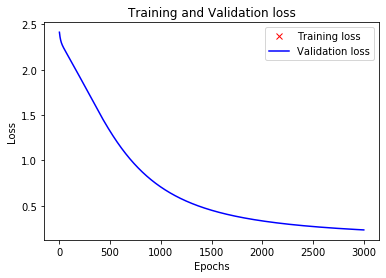

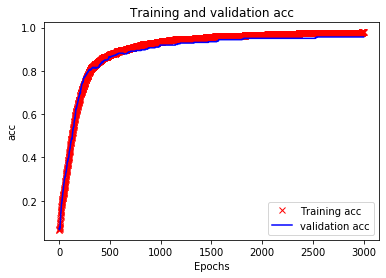

In [16]:
drow(history)